- coisas para add 
    - data augmentation DONE 
    - matriz de confusao  DONE 
    - acuracia ao longo do tempo DONE 
    - nova ativacao(leaky relu) 
    - tamanho dos modelos e arquiteura final 

# Imports

In [49]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

# Helper functions and MLP class

In [50]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function, dropout_rate, use_batch_norm=True):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            
            if use_batch_norm and i < len(layers_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
            x = self.dropout(x)

        x = self.layers[-1](x)
        
        return x 

In [51]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val):
    plt.plot(arr_acc_train, label = "train accuracy")
    plt.plot(arr_acc_val, label = "val accuracy")
    plt.plot(arr_acc_test, label = "test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    # reg params
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    n_layers = trial.suggest_int('n_layers', 2, 7)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(50):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval() # disable dropout just to validate
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [52]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats funciona melhor
])

# Transformação apenas para validação e teste (sem augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

validation_dataset.dataset.transform = transform_test

In [53]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [54]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [55]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [56]:
n_trials=1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-14 21:04:17,220] A new study created in memory with name: no-name-c7334943-90ba-4a89-bc1b-5a33acb8005d
[I 2025-06-14 21:04:23,522] Trial 0 finished with value: 2.181174159049988 and parameters: {'activation': 'Tanh', 'learning_rate': 2.722806845286745e-05, 'batch_size': 257, 'dropout_rate': 0.14420155481963093, 'weight_decay': 0.0059779083299269856, 'use_batch_norm': True, 'n_layers': 7, 'n_units_l0': 97, 'n_units_l1': 241, 'n_units_l2': 231, 'n_units_l3': 32, 'n_units_l4': 175, 'n_units_l5': 38, 'n_units_l6': 165}. Best is trial 0 with value: 2.181174159049988.


## Best founded model

In [57]:
study.best_params

{'activation': 'Tanh',
 'learning_rate': 2.722806845286745e-05,
 'batch_size': 257,
 'dropout_rate': 0.14420155481963093,
 'weight_decay': 0.0059779083299269856,
 'use_batch_norm': True,
 'n_layers': 7,
 'n_units_l0': 97,
 'n_units_l1': 241,
 'n_units_l2': 231,
 'n_units_l3': 32,
 'n_units_l4': 175,
 'n_units_l5': 38,
 'n_units_l6': 165}

In [58]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [59]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

arr_acc_train = []
arr_acc_test  = []
arr_acc_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    mlp.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    train_acc = evaluate_accuracy(mlp, train_loader)
    val_acc   = evaluate_accuracy(mlp, val_loader)
    test_acc  = evaluate_accuracy(mlp, test_loader)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    arr_acc_train.append(train_acc)
    arr_acc_val.append(val_acc)
    arr_acc_test.append(test_acc)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break

  0%|          | 1/10000 [00:00<1:01:16,  2.72it/s]

Epoch 1:
Train Loss: 2.3029
Val Loss: 2.3020
Test Loss: 2.3019


  0%|          | 2/10000 [00:00<1:00:21,  2.76it/s]

Epoch 2:
Train Loss: 2.2999
Val Loss: 2.3010
Test Loss: 2.3009


  0%|          | 3/10000 [00:01<1:00:12,  2.77it/s]

Epoch 3:
Train Loss: 2.3012
Val Loss: 2.3001
Test Loss: 2.2998


  0%|          | 4/10000 [00:01<59:55,  2.78it/s]  

Epoch 4:
Train Loss: 2.2999
Val Loss: 2.2992
Test Loss: 2.2988


  0%|          | 5/10000 [00:01<59:47,  2.79it/s]

Epoch 5:
Train Loss: 2.2956
Val Loss: 2.2983
Test Loss: 2.2979


  0%|          | 6/10000 [00:02<59:49,  2.78it/s]

Epoch 6:
Train Loss: 2.2948
Val Loss: 2.2975
Test Loss: 2.2970


  0%|          | 7/10000 [00:02<1:00:05,  2.77it/s]

Epoch 7:
Train Loss: 2.2956
Val Loss: 2.2967
Test Loss: 2.2961


  0%|          | 8/10000 [00:02<1:01:30,  2.71it/s]

Epoch 8:
Train Loss: 2.2965
Val Loss: 2.2959
Test Loss: 2.2952


  0%|          | 9/10000 [00:03<1:01:28,  2.71it/s]

Epoch 9:
Train Loss: 2.2927
Val Loss: 2.2950
Test Loss: 2.2943


  0%|          | 10/10000 [00:03<1:01:11,  2.72it/s]

Epoch 10:
Train Loss: 2.2910
Val Loss: 2.2942
Test Loss: 2.2934


  0%|          | 11/10000 [00:04<1:01:05,  2.73it/s]

Epoch 11:
Train Loss: 2.2908
Val Loss: 2.2933
Test Loss: 2.2924


  0%|          | 12/10000 [00:04<1:00:41,  2.74it/s]

Epoch 12:
Train Loss: 2.2885
Val Loss: 2.2924
Test Loss: 2.2914


  0%|          | 13/10000 [00:04<1:00:35,  2.75it/s]

Epoch 13:
Train Loss: 2.2860
Val Loss: 2.2915
Test Loss: 2.2903


  0%|          | 14/10000 [00:05<1:00:18,  2.76it/s]

Epoch 14:
Train Loss: 2.2856
Val Loss: 2.2905
Test Loss: 2.2892


  0%|          | 15/10000 [00:05<1:00:06,  2.77it/s]

Epoch 15:
Train Loss: 2.2815
Val Loss: 2.2894
Test Loss: 2.2880


  0%|          | 16/10000 [00:05<1:00:04,  2.77it/s]

Epoch 16:
Train Loss: 2.2817
Val Loss: 2.2883
Test Loss: 2.2867


  0%|          | 17/10000 [00:06<59:53,  2.78it/s]  

Epoch 17:
Train Loss: 2.2804
Val Loss: 2.2871
Test Loss: 2.2854


  0%|          | 18/10000 [00:06<59:51,  2.78it/s]

Epoch 18:
Train Loss: 2.2760
Val Loss: 2.2859
Test Loss: 2.2840


  0%|          | 19/10000 [00:06<1:00:12,  2.76it/s]

Epoch 19:
Train Loss: 2.2781
Val Loss: 2.2845
Test Loss: 2.2824


  0%|          | 20/10000 [00:07<1:00:12,  2.76it/s]

Epoch 20:
Train Loss: 2.2751
Val Loss: 2.2831
Test Loss: 2.2808


  0%|          | 21/10000 [00:07<59:56,  2.77it/s]  

Epoch 21:
Train Loss: 2.2747
Val Loss: 2.2816
Test Loss: 2.2790


  0%|          | 22/10000 [00:07<59:45,  2.78it/s]

Epoch 22:
Train Loss: 2.2723
Val Loss: 2.2800
Test Loss: 2.2772


  0%|          | 23/10000 [00:08<1:00:22,  2.75it/s]

Epoch 23:
Train Loss: 2.2667
Val Loss: 2.2783
Test Loss: 2.2753


  0%|          | 24/10000 [00:08<1:00:10,  2.76it/s]

Epoch 24:
Train Loss: 2.2654
Val Loss: 2.2765
Test Loss: 2.2732


  0%|          | 25/10000 [00:09<1:00:30,  2.75it/s]

Epoch 25:
Train Loss: 2.2648
Val Loss: 2.2745
Test Loss: 2.2709


  0%|          | 26/10000 [00:09<1:00:17,  2.76it/s]

Epoch 26:
Train Loss: 2.2613
Val Loss: 2.2725
Test Loss: 2.2686


  0%|          | 27/10000 [00:09<59:57,  2.77it/s]  

Epoch 27:
Train Loss: 2.2600
Val Loss: 2.2703
Test Loss: 2.2661


  0%|          | 28/10000 [00:10<59:58,  2.77it/s]

Epoch 28:
Train Loss: 2.2561
Val Loss: 2.2681
Test Loss: 2.2634


  0%|          | 29/10000 [00:10<1:00:05,  2.77it/s]

Epoch 29:
Train Loss: 2.2528
Val Loss: 2.2657
Test Loss: 2.2607


  0%|          | 30/10000 [00:10<59:51,  2.78it/s]  

Epoch 30:
Train Loss: 2.2512
Val Loss: 2.2632
Test Loss: 2.2578


  0%|          | 31/10000 [00:11<59:52,  2.78it/s]

Epoch 31:
Train Loss: 2.2450
Val Loss: 2.2605
Test Loss: 2.2548


  0%|          | 32/10000 [00:11<59:56,  2.77it/s]

Epoch 32:
Train Loss: 2.2406
Val Loss: 2.2578
Test Loss: 2.2516


  0%|          | 33/10000 [00:11<1:00:31,  2.74it/s]

Epoch 33:
Train Loss: 2.2395
Val Loss: 2.2548
Test Loss: 2.2482


  0%|          | 34/10000 [00:12<1:00:33,  2.74it/s]

Epoch 34:
Train Loss: 2.2367
Val Loss: 2.2518
Test Loss: 2.2447


  0%|          | 35/10000 [00:12<1:00:17,  2.75it/s]

Epoch 35:
Train Loss: 2.2278
Val Loss: 2.2485
Test Loss: 2.2409


  0%|          | 36/10000 [00:13<1:00:13,  2.76it/s]

Epoch 36:
Train Loss: 2.2275
Val Loss: 2.2452
Test Loss: 2.2371


  0%|          | 37/10000 [00:13<59:48,  2.78it/s]  

Epoch 37:
Train Loss: 2.2219
Val Loss: 2.2417
Test Loss: 2.2330


  0%|          | 38/10000 [00:13<59:42,  2.78it/s]

Epoch 38:
Train Loss: 2.2163
Val Loss: 2.2381
Test Loss: 2.2288


  0%|          | 39/10000 [00:14<59:28,  2.79it/s]

Epoch 39:
Train Loss: 2.2130
Val Loss: 2.2344
Test Loss: 2.2246


  0%|          | 40/10000 [00:14<59:17,  2.80it/s]

Epoch 40:
Train Loss: 2.2091
Val Loss: 2.2306
Test Loss: 2.2202


  0%|          | 41/10000 [00:14<59:13,  2.80it/s]

Epoch 41:
Train Loss: 2.2034
Val Loss: 2.2267
Test Loss: 2.2157


  0%|          | 42/10000 [00:15<58:42,  2.83it/s]

Epoch 42:
Train Loss: 2.1972
Val Loss: 2.2227
Test Loss: 2.2112


  0%|          | 43/10000 [00:15<58:30,  2.84it/s]

Epoch 43:
Train Loss: 2.1948
Val Loss: 2.2186
Test Loss: 2.2067


  0%|          | 44/10000 [00:15<58:32,  2.83it/s]

Epoch 44:
Train Loss: 2.1880
Val Loss: 2.2145
Test Loss: 2.2021


  0%|          | 45/10000 [00:16<58:48,  2.82it/s]

Epoch 45:
Train Loss: 2.1830
Val Loss: 2.2102
Test Loss: 2.1974


  0%|          | 46/10000 [00:16<58:50,  2.82it/s]

Epoch 46:
Train Loss: 2.1727
Val Loss: 2.2057
Test Loss: 2.1925


  0%|          | 47/10000 [00:16<58:53,  2.82it/s]

Epoch 47:
Train Loss: 2.1698
Val Loss: 2.2014
Test Loss: 2.1877


  0%|          | 48/10000 [00:17<58:58,  2.81it/s]

Epoch 48:
Train Loss: 2.1610
Val Loss: 2.1970
Test Loss: 2.1829


  0%|          | 49/10000 [00:17<59:01,  2.81it/s]

Epoch 49:
Train Loss: 2.1569
Val Loss: 2.1927
Test Loss: 2.1782


  0%|          | 50/10000 [00:18<58:59,  2.81it/s]

Epoch 50:
Train Loss: 2.1507
Val Loss: 2.1884
Test Loss: 2.1736


  1%|          | 51/10000 [00:18<58:59,  2.81it/s]

Epoch 51:
Train Loss: 2.1391
Val Loss: 2.1840
Test Loss: 2.1686


  1%|          | 52/10000 [00:18<58:37,  2.83it/s]

Epoch 52:
Train Loss: 2.1337
Val Loss: 2.1796
Test Loss: 2.1638


  1%|          | 53/10000 [00:19<58:38,  2.83it/s]

Epoch 53:
Train Loss: 2.1331
Val Loss: 2.1754
Test Loss: 2.1592


  1%|          | 54/10000 [00:19<58:35,  2.83it/s]

Epoch 54:
Train Loss: 2.1216
Val Loss: 2.1716
Test Loss: 2.1551


  1%|          | 55/10000 [00:19<58:35,  2.83it/s]

Epoch 55:
Train Loss: 2.1166
Val Loss: 2.1678
Test Loss: 2.1512


  1%|          | 56/10000 [00:20<58:50,  2.82it/s]

Epoch 56:
Train Loss: 2.1070
Val Loss: 2.1637
Test Loss: 2.1467


  1%|          | 57/10000 [00:20<58:39,  2.83it/s]

Epoch 57:
Train Loss: 2.0997
Val Loss: 2.1593
Test Loss: 2.1417


  1%|          | 58/10000 [00:20<58:35,  2.83it/s]

Epoch 58:
Train Loss: 2.0968
Val Loss: 2.1550
Test Loss: 2.1373


  1%|          | 59/10000 [00:21<58:34,  2.83it/s]

Epoch 59:
Train Loss: 2.0926
Val Loss: 2.1514
Test Loss: 2.1332


  1%|          | 60/10000 [00:21<58:33,  2.83it/s]

Epoch 60:
Train Loss: 2.0856
Val Loss: 2.1479
Test Loss: 2.1294


  1%|          | 61/10000 [00:21<58:40,  2.82it/s]

Epoch 61:
Train Loss: 2.0748
Val Loss: 2.1444
Test Loss: 2.1255


  1%|          | 62/10000 [00:22<58:59,  2.81it/s]

Epoch 62:
Train Loss: 2.0670
Val Loss: 2.1401
Test Loss: 2.1210


  1%|          | 63/10000 [00:22<59:05,  2.80it/s]

Epoch 63:
Train Loss: 2.0685
Val Loss: 2.1367
Test Loss: 2.1170


  1%|          | 64/10000 [00:22<59:04,  2.80it/s]

Epoch 64:
Train Loss: 2.0594
Val Loss: 2.1327
Test Loss: 2.1128


  1%|          | 65/10000 [00:23<58:56,  2.81it/s]

Epoch 65:
Train Loss: 2.0466
Val Loss: 2.1297
Test Loss: 2.1096


  1%|          | 66/10000 [00:23<59:00,  2.81it/s]

Epoch 66:
Train Loss: 2.0450
Val Loss: 2.1273
Test Loss: 2.1077


  1%|          | 67/10000 [00:24<58:42,  2.82it/s]

Epoch 67:
Train Loss: 2.0382
Val Loss: 2.1231
Test Loss: 2.1028


  1%|          | 68/10000 [00:24<58:29,  2.83it/s]

Epoch 68:
Train Loss: 2.0281
Val Loss: 2.1200
Test Loss: 2.0993


  1%|          | 69/10000 [00:24<58:19,  2.84it/s]

Epoch 69:
Train Loss: 2.0211
Val Loss: 2.1172
Test Loss: 2.0966


  1%|          | 70/10000 [00:25<58:54,  2.81it/s]

Epoch 70:
Train Loss: 2.0160
Val Loss: 2.1156
Test Loss: 2.0951


  1%|          | 71/10000 [00:25<59:43,  2.77it/s]

Epoch 71:
Train Loss: 2.0124
Val Loss: 2.1126
Test Loss: 2.0919


  1%|          | 72/10000 [00:25<1:02:03,  2.67it/s]

Epoch 72:
Train Loss: 2.0011
Val Loss: 2.1091
Test Loss: 2.0872


  1%|          | 73/10000 [00:26<1:01:26,  2.69it/s]

Epoch 73:
Train Loss: 1.9976
Val Loss: 2.1064
Test Loss: 2.0842


  1%|          | 74/10000 [00:26<1:02:59,  2.63it/s]

Epoch 74:
Train Loss: 1.9898
Val Loss: 2.1043
Test Loss: 2.0824


  1%|          | 75/10000 [00:27<1:02:20,  2.65it/s]

Epoch 75:
Train Loss: 1.9805
Val Loss: 2.1018
Test Loss: 2.0795


  1%|          | 76/10000 [00:27<1:01:08,  2.71it/s]

Epoch 76:
Train Loss: 1.9785
Val Loss: 2.0986
Test Loss: 2.0761


  1%|          | 77/10000 [00:27<1:00:12,  2.75it/s]

Epoch 77:
Train Loss: 1.9690
Val Loss: 2.0972
Test Loss: 2.0753


  1%|          | 78/10000 [00:28<1:00:00,  2.76it/s]

Epoch 78:
Train Loss: 1.9685
Val Loss: 2.0941
Test Loss: 2.0715


  1%|          | 79/10000 [00:28<59:34,  2.78it/s]  

Epoch 79:
Train Loss: 1.9594
Val Loss: 2.0919
Test Loss: 2.0687


  1%|          | 80/10000 [00:28<59:09,  2.79it/s]

Epoch 80:
Train Loss: 1.9515
Val Loss: 2.0910
Test Loss: 2.0689


  1%|          | 81/10000 [00:29<59:18,  2.79it/s]

Epoch 81:
Train Loss: 1.9483
Val Loss: 2.0875
Test Loss: 2.0655


  1%|          | 82/10000 [00:29<59:13,  2.79it/s]

Epoch 82:
Train Loss: 1.9436
Val Loss: 2.0844
Test Loss: 2.0633


  1%|          | 83/10000 [00:29<59:05,  2.80it/s]

Epoch 83:
Train Loss: 1.9326
Val Loss: 2.0825
Test Loss: 2.0624


  1%|          | 84/10000 [00:30<58:53,  2.81it/s]

Epoch 84:
Train Loss: 1.9268
Val Loss: 2.0805
Test Loss: 2.0615


  1%|          | 85/10000 [00:30<58:47,  2.81it/s]

Epoch 85:
Train Loss: 1.9143
Val Loss: 2.0771
Test Loss: 2.0590


  1%|          | 86/10000 [00:30<58:46,  2.81it/s]

Epoch 86:
Train Loss: 1.9172
Val Loss: 2.0757
Test Loss: 2.0586


  1%|          | 87/10000 [00:31<59:17,  2.79it/s]

Epoch 87:
Train Loss: 1.9053
Val Loss: 2.0732
Test Loss: 2.0553


  1%|          | 88/10000 [00:31<59:26,  2.78it/s]

Epoch 88:
Train Loss: 1.9027
Val Loss: 2.0713
Test Loss: 2.0542


  1%|          | 89/10000 [00:32<59:33,  2.77it/s]

Epoch 89:
Train Loss: 1.8898
Val Loss: 2.0729
Test Loss: 2.0570


  1%|          | 90/10000 [00:32<59:31,  2.78it/s]

Epoch 90:
Train Loss: 1.8890
Val Loss: 2.0686
Test Loss: 2.0539


  1%|          | 91/10000 [00:32<59:58,  2.75it/s]

Epoch 91:
Train Loss: 1.8829
Val Loss: 2.0663
Test Loss: 2.0523


  1%|          | 92/10000 [00:33<1:00:00,  2.75it/s]

Epoch 92:
Train Loss: 1.8720
Val Loss: 2.0663
Test Loss: 2.0514


  1%|          | 93/10000 [00:33<59:53,  2.76it/s]  

Epoch 93:
Train Loss: 1.8647
Val Loss: 2.0655
Test Loss: 2.0505


  1%|          | 94/10000 [00:33<59:32,  2.77it/s]

Epoch 94:
Train Loss: 1.8594
Val Loss: 2.0629
Test Loss: 2.0490


  1%|          | 95/10000 [00:34<59:10,  2.79it/s]

Epoch 95:
Train Loss: 1.8486
Val Loss: 2.0640
Test Loss: 2.0521


  1%|          | 96/10000 [00:34<58:44,  2.81it/s]

Epoch 96:
Train Loss: 1.8443
Val Loss: 2.0601
Test Loss: 2.0482


  1%|          | 97/10000 [00:34<58:33,  2.82it/s]

Epoch 97:
Train Loss: 1.8439
Val Loss: 2.0596
Test Loss: 2.0483


  1%|          | 98/10000 [00:35<58:43,  2.81it/s]

Epoch 98:
Train Loss: 1.8383
Val Loss: 2.0645
Test Loss: 2.0538


  1%|          | 99/10000 [00:35<58:38,  2.81it/s]

Epoch 99:
Train Loss: 1.8180
Val Loss: 2.0594
Test Loss: 2.0480


  1%|          | 100/10000 [00:35<58:29,  2.82it/s]

Epoch 100:
Train Loss: 1.8193
Val Loss: 2.0581
Test Loss: 2.0479


  1%|          | 101/10000 [00:36<58:20,  2.83it/s]

Epoch 101:
Train Loss: 1.8190
Val Loss: 2.0600
Test Loss: 2.0513


  1%|          | 102/10000 [00:36<59:02,  2.79it/s]

Epoch 102:
Train Loss: 1.7963
Val Loss: 2.0561
Test Loss: 2.0491


  1%|          | 103/10000 [00:37<59:17,  2.78it/s]

Epoch 103:
Train Loss: 1.7941
Val Loss: 2.0553
Test Loss: 2.0500


  1%|          | 104/10000 [00:37<59:19,  2.78it/s]

Epoch 104:
Train Loss: 1.7921
Val Loss: 2.0579
Test Loss: 2.0541


  1%|          | 105/10000 [00:37<59:14,  2.78it/s]

Epoch 105:
Train Loss: 1.7837
Val Loss: 2.0572
Test Loss: 2.0544


  1%|          | 106/10000 [00:38<59:42,  2.76it/s]

Epoch 106:
Train Loss: 1.7735
Val Loss: 2.0579
Test Loss: 2.0569


  1%|          | 107/10000 [00:38<59:47,  2.76it/s]

Epoch 107:
Train Loss: 1.7702
Val Loss: 2.0586
Test Loss: 2.0588


  1%|          | 107/10000 [00:38<59:51,  2.75it/s]

Epoch 108:
Train Loss: 1.7620
Val Loss: 2.0555
Test Loss: 2.0547
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

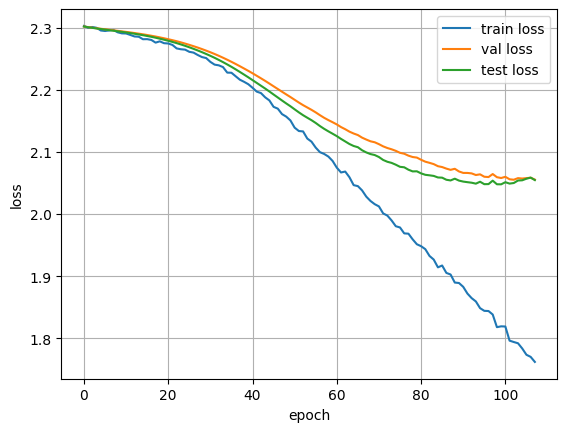

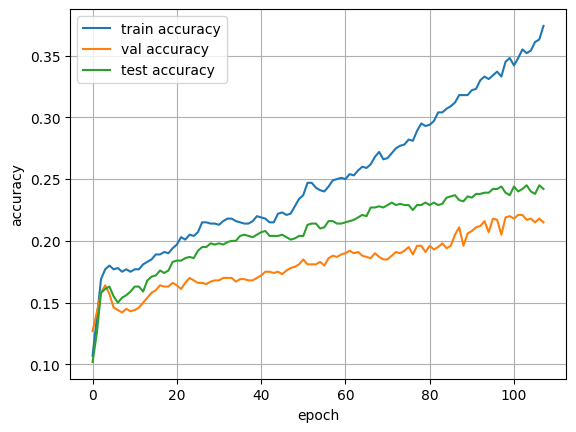

In [60]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

plt.figure()  
show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.2477095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39626682..1.6792717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37057972..1.7851416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2421

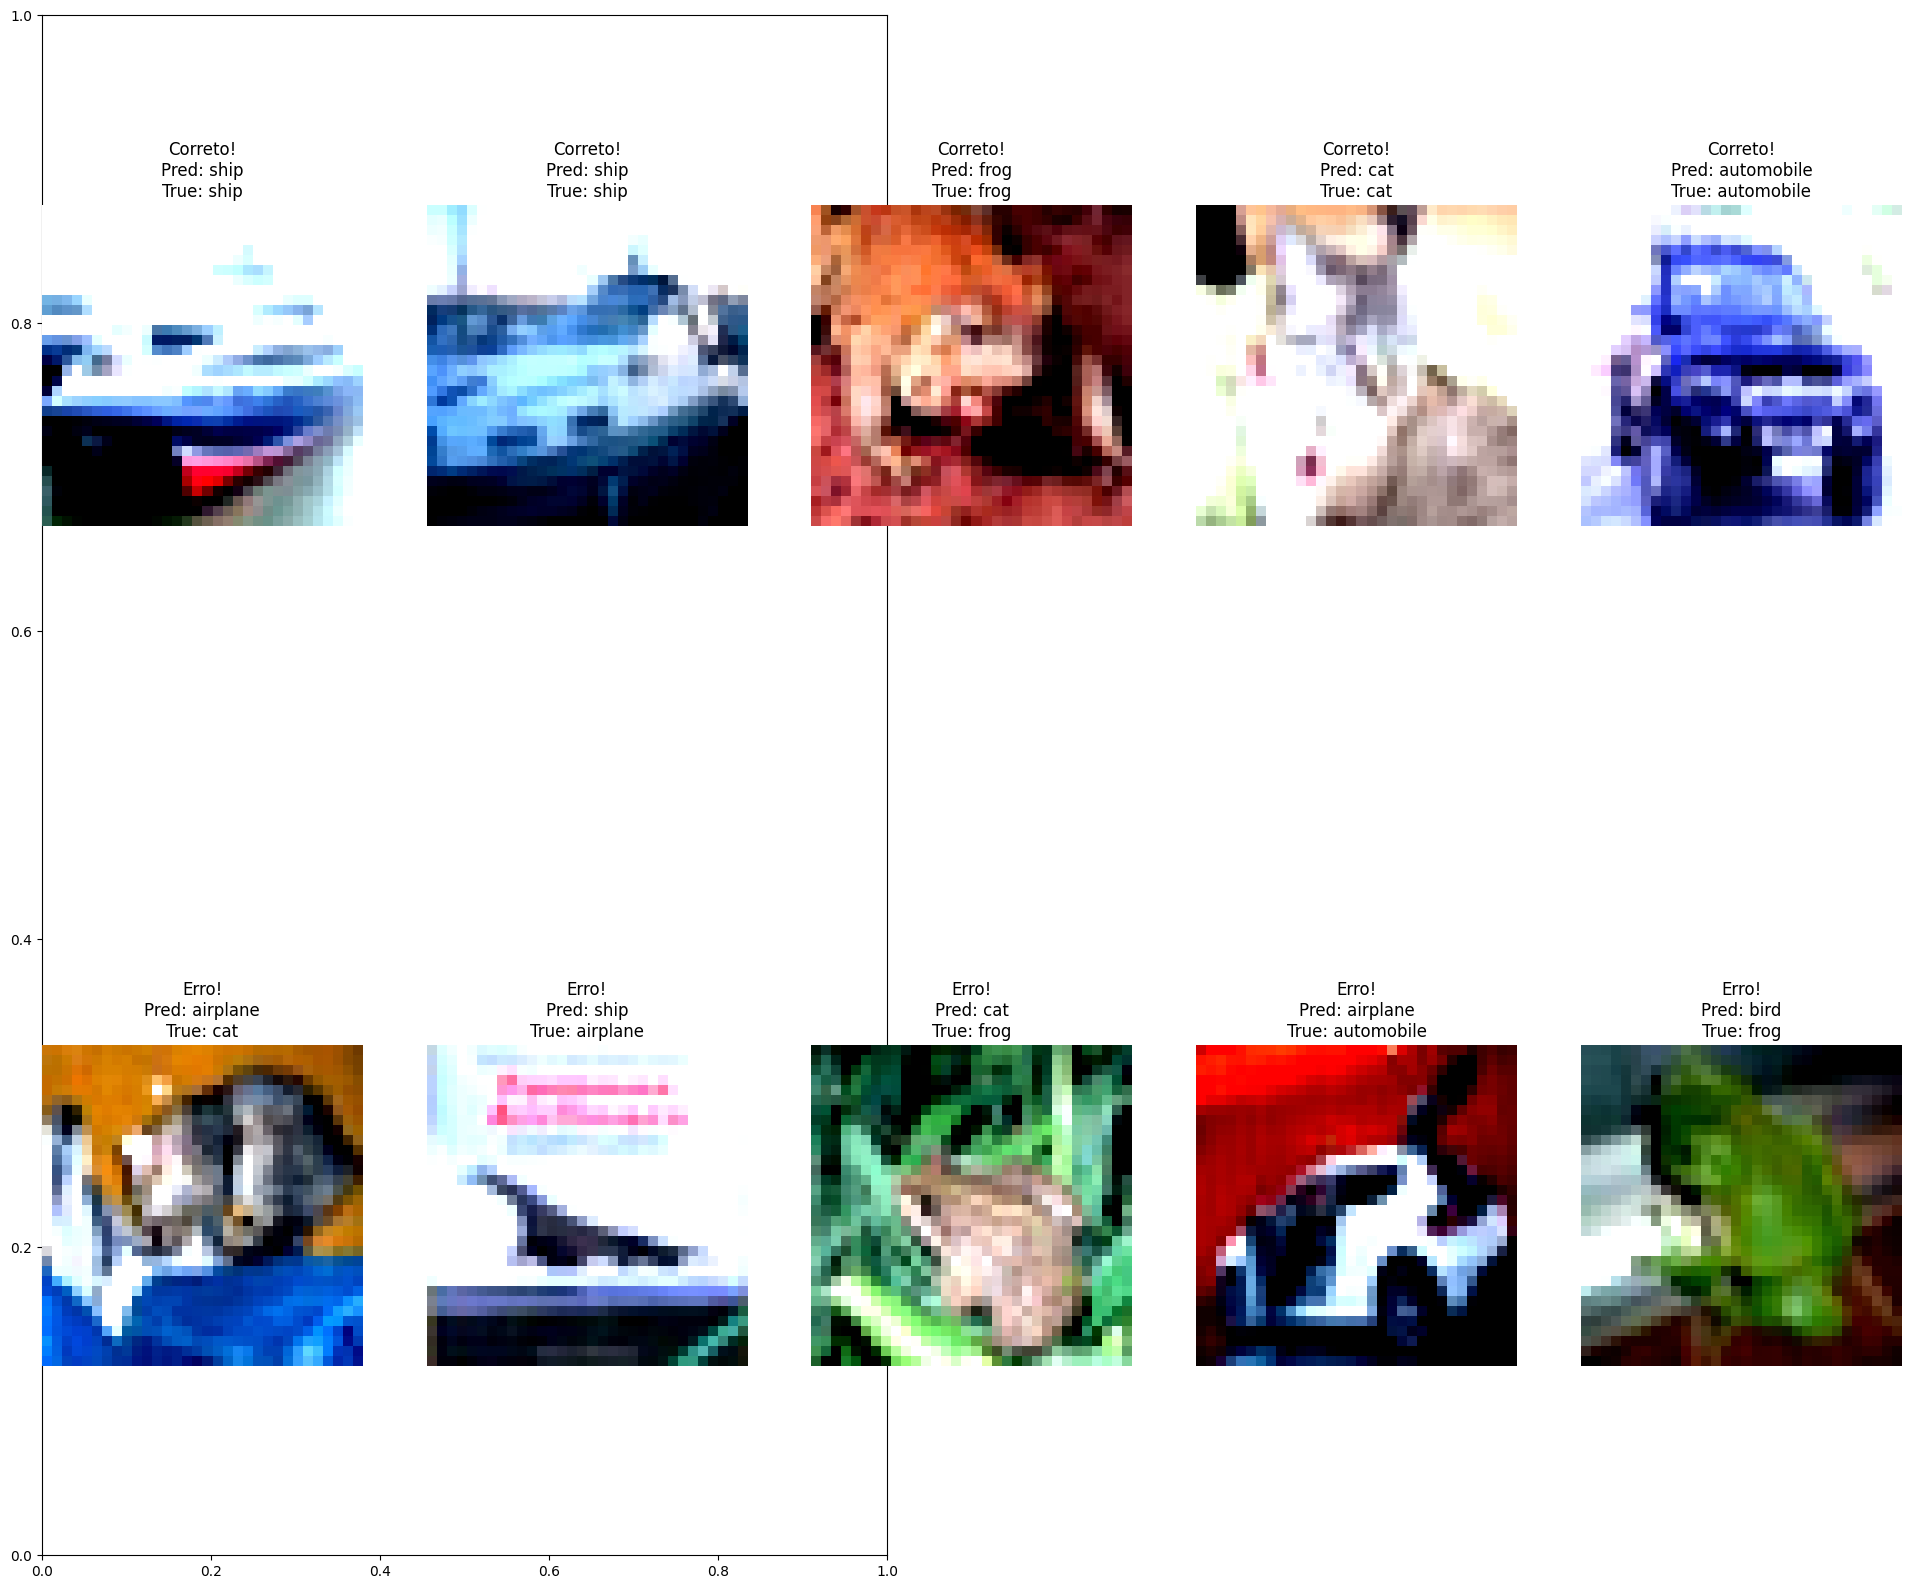

In [61]:
show_predictions(mlp, test_loader, num_samples=5)

In [62]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.242, 'balanced_accuracy': np.float64(0.23479809521213174), 'f1_score': 0.16925512102399473, 'precision': 0.2135101143878341, 'recall': 0.242}




/home/eduardoamorim/Área de trabalho/cin_2025_1/NN/nn-exps/.venvNN/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 1000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 18.45%
  Número de amostras: 103
  Representatividade: 10.30%

automobile:
  Acurácia: 49.44%
  Número de amostras: 89
  Representatividade: 8.90%

bird:
  Acurácia: 5.00%
  Número de amostras: 100
  Representatividade: 10.00%

cat:
  Acurácia: 32.04%
  Número de amostras: 103
  Representatividade: 10.30%

deer:
  Acurácia: 1.11%
  Número de amostras: 90
  Representatividade: 9.00%

dog:
  Acurácia: 0.00%
  Número de amostras: 86
  Representatividade: 8.60%

frog:
  Acurácia: 59.82%
  Número de amostras: 112
  Representatividade: 11.20%

horse:
  Acurácia: 1.96%
  Número de amostras: 102
  Representatividade: 10.20%

ship:
  Acurácia: 66.98%
  Número de amostras: 106
  Representatividade: 10.60%

truck:
  Acurácia: 0.00%
  Número de amostras: 109
  Representatividade: 10.90%


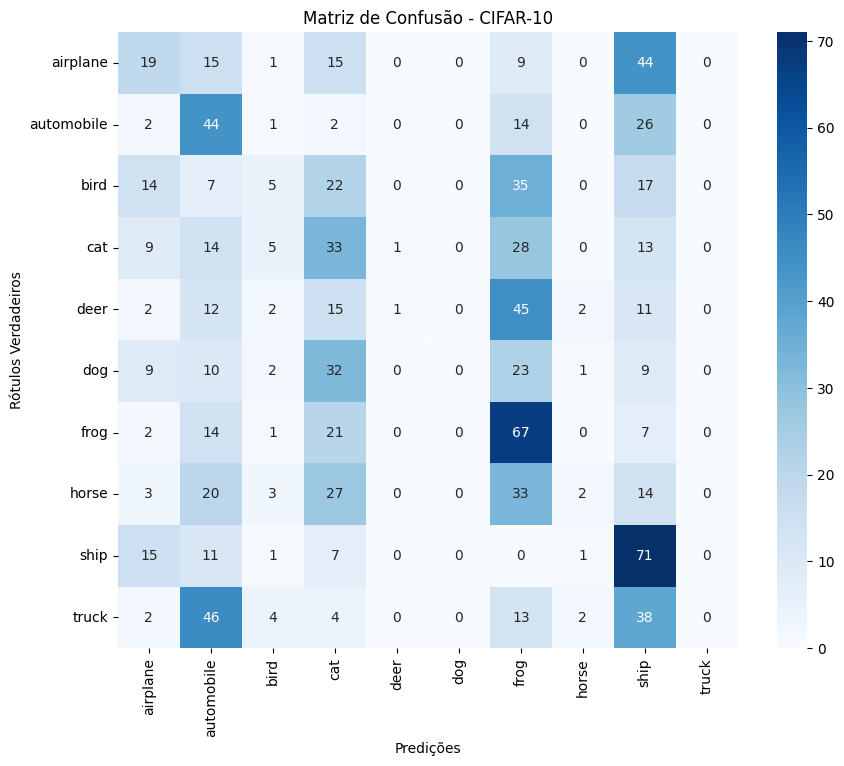

TRUE -> PRED
1. truck → automobile: 46 vezes
2. deer → frog: 45 vezes
3. airplane → ship: 44 vezes
4. truck → ship: 38 vezes
5. bird → frog: 35 vezes


In [64]:
cm = metrics.confusion_matrix(labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - CIFAR-10')
plt.xlabel('Predições')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

flat_indices = np.argsort(cm_errors.ravel())[::-1][:5]
confusion_indices = np.unravel_index(flat_indices, cm_errors.shape)

print(f"TRUE -> PRED")
for i in range(5):
    true_class = confusion_indices[0][i]
    pred_class = confusion_indices[1][i]
    count = cm_errors[true_class, pred_class]
    if count > 0:
        print(f"{i+1}. {classes[true_class]} → {classes[pred_class]}: {count} vezes")